In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import pandas as pd 
from os import system as sys 
import seaborn as sns
#pd.reset_option('all')

In [2]:
use_f = ['var_mean' , 'var_sigma','cnts_aper', 'flux_aper','flux_aper_hilim' , 'flux_aper_lolim' , 'flux_significance']
filters = ['_h' ,'_m' ,'_s' ,'_u' ,'_b']

In [3]:

def hr():
    print('____________________________________________________')


def to_float(d):
    temp = []
    for di in d:
        try:
            temp.append(float(di))
        except Exception as e:
            print(e)
            print('NaN detected resetting value')
            temp.append(np.NAN)
    temp = np.asarray(temp)
    return temp 

In [4]:
def get_obs_val(file):
    data = pd.read_csv(file, delimiter='\t' , comment='#')
    data = data[data['match_type']=='u          ']
    data = data[data['instrument']=='ACIS']
    #------master info 

    hard_hm = np.asarray([float(f) for f in data['hard_hm']])
    hard_ms = np.asarray([float(f) for f in data['hard_ms']])
    hard_ratio =  []
    ##find out names for ech observation
    obs_name = data['name']
    for h,m in zip(hard_hm , hard_ms):
        if(m>0):
            hard_ratio.append(h/m)
        else:
            hard_ratio.append(np.NAN)

    #data.sort_values(by=['gti_obs'] , inplace=True)
    rows = ['livetime' ,'gti_obs']
    for f in filters:
        for r in use_f:
            rows.append(r+f)
    #print(rows)
    data_all = data[rows]
    dates =data_all['gti_obs']
    data_all = data_all.drop(columns=['gti_obs'])
    #print(data_all)
    for j in data_all[:10]:
        data_all[j] = to_float(data_all[j])
    #print(data_all)
    data_mean = pd.DataFrame()
    i = 0
    for r in use_f:
        prop = []
        for f in filters:
            prop.append(r+f)
        temp = data_all[prop].mean(axis=1)
        data_mean.insert(i , r , temp)
        i+=1


    data_mean.insert(0 , 'hardness' , hard_ratio)
    data_mean.insert(0 , 'date' , dates)
    data_mean.insert(0 , 'exp_time' , data_all['livetime'])
    ## include cluster names in the returned dataframe
    # file[:16] means keep only cluster name and not directory
    data_mean.insert(0, 'cl_name', [file[17:]]*len(data_mean))
    #include each observation name
    data_mean.insert(1, 'obs_name', obs_name)
    #print(data_mean)
    data_mean.dropna(axis=0 , how='any')
    flux = data_mean['flux_aper']
    hardness = data_mean['hardness']
    return flux, hardness , data_mean 


In [5]:
from ipywidgets import IntProgress
from IPython.display import display

sys('ls cluster_obs_data > cl_files.txt')
cl_files = pd.read_csv('cl_files.txt' , names=['cl_name'])['cl_name']
if(len(cl_files)>0):
    #flux = np.asarray([])
    #hardness = np.asarray([])
    #dataframe stores cluster name , obs_name , flux , hardness
    obs_data = pd.DataFrame() 
    f = IntProgress(min=0, max=len(cl_files)) # instantiate the bar
    display(f)
    for c in cl_files:
        #print(c)
        #plot_cl('cluster_obs_data/'+c)
        f.value+=1
        try:
            _,_ , d =  get_obs_val('cluster_obs_data/'+c)
            #print(f.shape)
            obs_data = obs_data.append(d)
        except Exception as e:
            #print(e)
            print('problem with ' , c)

desc = obs_data.describe()
display(desc)
desc.to_csv('temp_output.csv')


IntProgress(value=0, max=91)

/tmp/ipykernel_30338/1128550861.py:18: DtypeWarning: Columns (27,238,240,242,244,246,252,253) have mixed types.Specify dtype option on import or set low_memory=False.
  _,_ , d =  get_obs_val('cluster_obs_data/'+c)
/tmp/ipykernel_30338/1128550861.py:18: DtypeWarning: Columns (23,27,238,240,242,244,246,251,252,253,254,255,256,258,259) have mixed types.Specify dtype option on import or set low_memory=False.
  _,_ , d =  get_obs_val('cluster_obs_data/'+c)


,exp_time,hardness,var_mean,var_sigma,cnts_aper,flux_aper,flux_aper_hilim,flux_aper_lolim,flux_significance
count,17642.000000,5660.000000,11342.000000,1.134200e+04,17642.000000,1.695200e+04,1.695200e+04,1.695200e+04,17553.000000
mean,42808.258746,0.849573,0.032799,4.983845e-01,44.648334,4.322984e-13,6.737174e-13,2.084201e-13,1.911935
std,36000.912930,13.661280,0.612532,9.920191e+00,1044.670337,2.057535e-11,3.127099e-11,1.042235e-11,2.983770
min,845.100000,-399.760000,0.000023,2.177000e-12,0.000000,0.000000e+00,6.693000e-17,0.000000e+00,0.000000
25%,13510.550000,-0.104963,0.000246,2.190225e-05,2.400000,5.291600e-16,1.476445e-15,1.394089e-16,0.746000
50%,31673.800000,0.496198,0.000522,5.391250e-05,6.000000,1.978317e-15,3.898200e-15,8.480812e-16,1.358000
75%,59044.600000,1.011846,0.001216,1.332169e-04,17.200000,6.255500e-15,1.076741e-14,3.407975e-15,2.162000
max,173752.400000,333.280000,44.467915,7.483339e+02,115846.400000,2.110001e-09,3.084001e-09,1.136400e-09,116.862000


keep only those observations where flux significance is greater than a certain threshold value

In [6]:
# keep data only where flux significance is above threshold
th_significance = 3
obs_data_th = obs_data[obs_data['flux_significance']>th_significance]
obs_data_th.describe()

,exp_time,hardness,var_mean,var_sigma,cnts_aper,flux_aper,flux_aper_hilim,flux_aper_lolim,flux_significance
count,2520.000000,960.000000,2506.000000,2.506000e+03,2520.000000,2.517000e+03,2.517000e+03,2.517000e+03,2520.000000
mean,57555.806468,1.777077,0.032138,4.369257e-01,157.919206,6.575527e-13,9.851958e-13,3.540748e-13,6.077443
std,39568.012632,13.666540,0.899683,1.511839e+01,780.279740,1.354816e-11,1.925039e-11,8.163666e-12,6.184429
min,845.100000,-239.416667,0.000093,1.183000e-08,8.200000,6.501500e-16,8.831000e-16,3.899220e-16,3.002000
25%,29467.000000,0.435049,0.000742,4.826400e-05,27.600000,5.519000e-15,7.213750e-15,4.206250e-15,3.521500
50%,48584.400000,0.862113,0.001468,9.937667e-05,45.800000,1.209940e-14,1.604744e-14,9.305600e-15,4.353000
75%,68771.400000,1.628945,0.003259,2.524242e-04,98.000000,2.874625e-14,3.630580e-14,2.308475e-14,6.285500
max,173752.400000,208.166667,44.467915,7.483339e+02,23671.600000,5.660075e-10,7.408198e-10,3.809948e-10,116.862000


## Flux

In [7]:
flux_data = obs_data_th[['cl_name' , 'obs_name' ,'flux_significance', 'flux_aper' , 'flux_aper_lolim' , 'flux_aper_hilim']]
flux_data.describe()

,flux_significance,flux_aper,flux_aper_lolim,flux_aper_hilim
count,2520.000000,2.517000e+03,2.517000e+03,2.517000e+03
mean,6.077443,6.575527e-13,3.540748e-13,9.851958e-13
std,6.184429,1.354816e-11,8.163666e-12,1.925039e-11
min,3.002000,6.501500e-16,3.899220e-16,8.831000e-16
25%,3.521500,5.519000e-15,4.206250e-15,7.213750e-15
50%,4.353000,1.209940e-14,9.305600e-15,1.604744e-14
75%,6.285500,2.874625e-14,2.308475e-14,3.630580e-14
max,116.862000,5.660075e-10,3.809948e-10,7.408198e-10


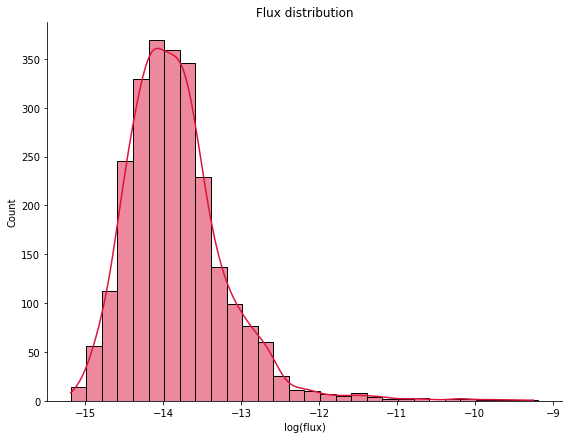

In [8]:
#plt.figure(figsize=(6,6))

sns.displot(np.log10(flux_data['flux_aper']) ,
    kde=True , 
    binwidth=0.2 , 
    color='crimson' , height=6, aspect=8/6
    )
plt.xlabel('log(flux)')
plt.title('Flux distribution')
plt.savefig('plots/flux_dist.jpg')
plt.show()

Lets Check which all sources are having higher flux , we can later study them individually to see if ther are in outburst or not .

In [9]:
flux_data_high = flux_data[flux_data['flux_aper']>1e-11]
display(flux_data_high[['cl_name' , 'obs_name' ,'flux_aper']])
#display(flux_data_high)

,cl_name,obs_name,flux_aper
30,120_GLIMPSE-02.csv,2CXO J181749.6-164859,1.368934e-11
250,120_GLIMPSE-02.csv,2CXO J181811.2-170152,2.230244e-11
589,120_GLIMPSE-02.csv,2CXO J181837.9-170248,5.660075e-10
86,138_NGC-6760.csv,2CXO J191134.1+010734,4.724889e-11
78,18_NGC-3201.csv,2CXO J101809.0-461835,1.667615e-11
452,28_NGC-5139.csv,2CXO J132730.1-471050,7.440413e-11
460,28_NGC-5139.csv,2CXO J132734.7-473237,6.336993e-11
461,28_NGC-5139.csv,2CXO J132734.7-473237,1.748099e-10
4,40_NGC-5927.csv,2CXO J152712.2-502555,2.421206e-11
17,66_NGC-6293.csv,2CXO J170930.3-263919,6.794100e-11


## Hardness

In [19]:
hard_data = obs_data_th[['cl_name' ,'obs_name' , 'flux_significance' , 'hardness']]
hard_data = hard_data.dropna(axis=0 , how='any')
hard_data.describe()

,flux_significance,hardness
count,960.000000,960.000000
mean,5.877780,1.777077
std,7.052141,13.666540
min,3.004000,-239.416667
25%,3.513500,0.435049
50%,4.347750,0.862113
75%,6.042750,1.628945
max,116.862000,208.166667


Very hard sources

In [30]:
hard_hi = hard_data[hard_data['hardness']>40]
display(hard_hi)
hard_hi.to_csv('temp_output.csv')

,cl_name,obs_name,flux_significance,hardness
403,104_NGC-6522.csv,2CXO J180323.0-300604,3.836,116.135135
43,106_NGC-6528.csv,2CXO J180323.0-300604,3.836,116.135135
279,28_NGC-5139.csv,2CXO J132653.5-472900,10.508,140.400000
825,89_NGC-6397.csv,2CXO J174058.2-534618,5.448,208.166667
913,89_NGC-6397.csv,2CXO J174105.2-533759,3.016,50.972973
5,93_Terzan-5.csv,2CXO J174716.3-244756,4.558,72.383929


ultra soft sources

In [28]:
hard_lo = hard_data[hard_data['hardness']<-20]
display(hard_lo[['cl_name' , 'obs_name' , 'hardness']])
hard_lo.to_csv('temp_output.csv')

,cl_name,obs_name,hardness
620,120_GLIMPSE-02.csv,2CXO J181840.5-165313,-239.416667
1002,123_NGC-6626.csv,2CXO J182433.7-245211,-48.161290
51,18_NGC-3201.csv,2CXO J101736.0-462422,-44.942529
26,1_NGC-288.csv,2CXO J005229.3-262553,-79.580645
202,94_NGC-6440.csv,2CXO J174852.8-202142,-35.589623


In [22]:
hard_mid = hard_data[hard_data['hardness']>-5]
hard_mid = hard_mid[hard_mid['hardness']<5]
#hard_mid = hard_mid[hard_mid['hardness']<10]
hard_mid.describe()

,flux_significance,hardness
count,871.000000,871.000000
mean,5.848225,0.943693
std,6.351938,1.195148
min,3.004000,-4.981162
25%,3.539000,0.429344
50%,4.357500,0.830881
75%,6.082500,1.396711
max,116.862000,4.995556


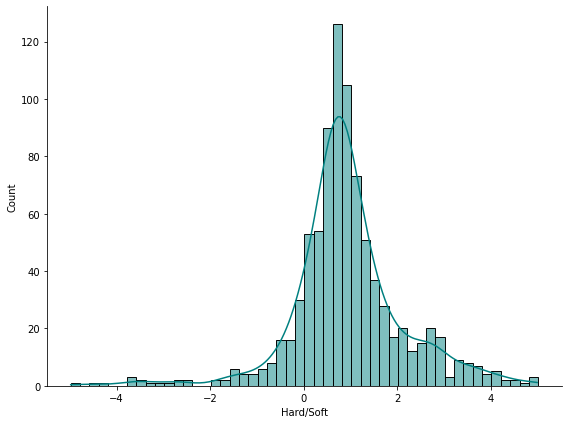

In [25]:
sns.displot((hard_mid['hardness']) ,
    kde=True , 
    binwidth=0.2 , 
    color='teal',
    height=6 , 
    aspect = 8/6
    )
plt.xlabel('Hard/Soft')
plt.savefig('plots/hardness.jpg')
plt.show()